# Ultrasound Nerve Segmentation

## Identify nerve structures in ultrasound images of the neck

<https://www.kaggle.com/c/ultrasound-nerve-segmentation>

> Even the bravest patient cringes at the mention of a surgical procedure. Surgery inevitably brings discomfort, and oftentimes involves significant post-surgical pain. Currently, patient pain is frequently managed through the use of narcotics that bring a bevy of unwanted side effects.
This competition's sponsor is working to improve pain management through the use of indwelling catheters that block or mitigate pain at the source. Pain management catheters reduce dependence on narcotics and speed up patient recovery.
**Accurately identifying nerve structures in ultrasound images is a critical step in effectively inserting a patient’s pain management catheter.** In this competition, Kagglers are challenged to build a model that can identify nerve structures in a dataset of ultrasound images of the neck. Doing so would improve catheter placement and contribute to a more pain free future. 

## Data

In [1]:
import os
import numpy as np
from skimage.io import imsave, imread
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data_path = '../raw/'

image_rows = 420
image_cols = 580

### Load the training images

In [3]:
train_data_path = os.path.join(data_path, 'train')
images = os.listdir(train_data_path)
total = len(images) // 2

In [4]:
train_imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)
train_imgs_mask = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)

i = 0
for image_name in tqdm_notebook(images):    
    if 'mask' in image_name:
        continue
        
    image_mask_name = image_name.split('.')[0] + '_mask.tif'
    img = imread(os.path.join(train_data_path, image_name), as_grey=True)
    img_mask = imread(os.path.join(train_data_path, image_mask_name), as_grey=True)

    img = np.array([img])
    img_mask = np.array([img_mask])

    train_imgs[i] = img
    train_imgs_mask[i] = img_mask
    i += 1

/home/alexej/tensorflow/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


#### Let's look at some of the training images and masks

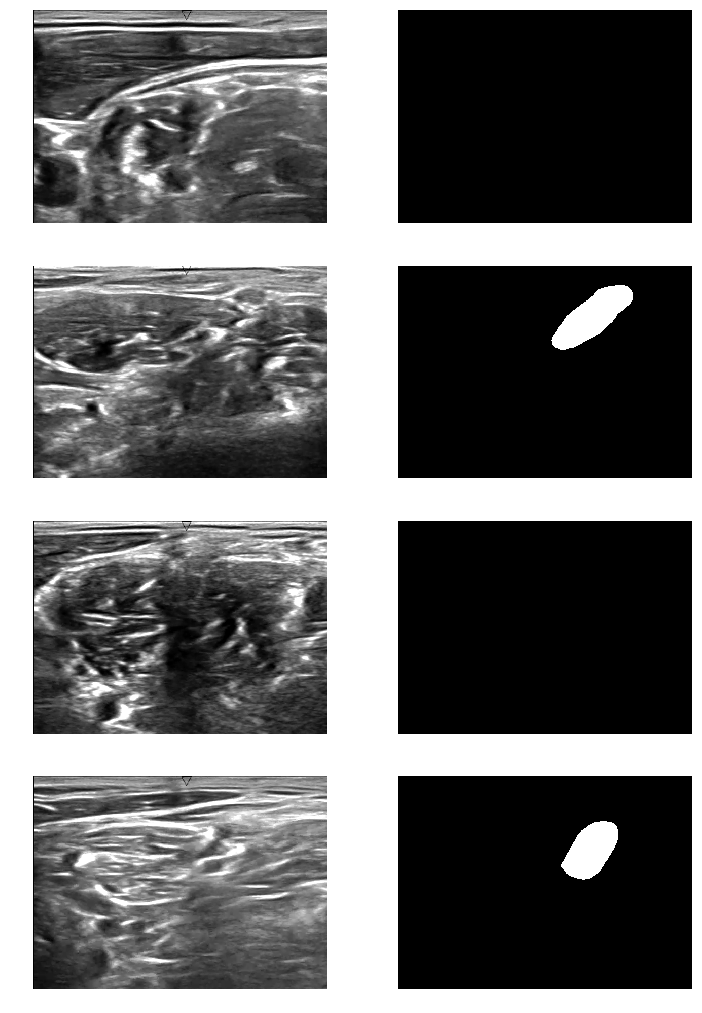

In [5]:
f = plt.figure(figsize=(12, 18))
for i in range(4):
    sp = f.add_subplot(4, 2, 2*i+1)
    sp.axis('Off')
    plt.imshow(train_imgs[i, :, :], cmap="gray")
    sp = f.add_subplot(4, 2, 2*i+2)
    sp.axis('Off')
    plt.imshow(train_imgs_mask[i, :, :], cmap="gray")

### Load the test images

In [6]:
test_data_path = os.path.join(data_path, 'test')
images = os.listdir(test_data_path)
total = len(images)

test_imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)
test_imgs_id = np.ndarray((total, ), dtype=np.int32)

i = 0
for image_name in tqdm_notebook(images):
    img_id = int(image_name.split('.')[0])
    img = imread(os.path.join(test_data_path, image_name), as_grey=True)

    img = np.array([img])

    test_imgs[i] = img
    test_imgs_id[i] = img_id
    i += 1

/home/alexej/tensorflow/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


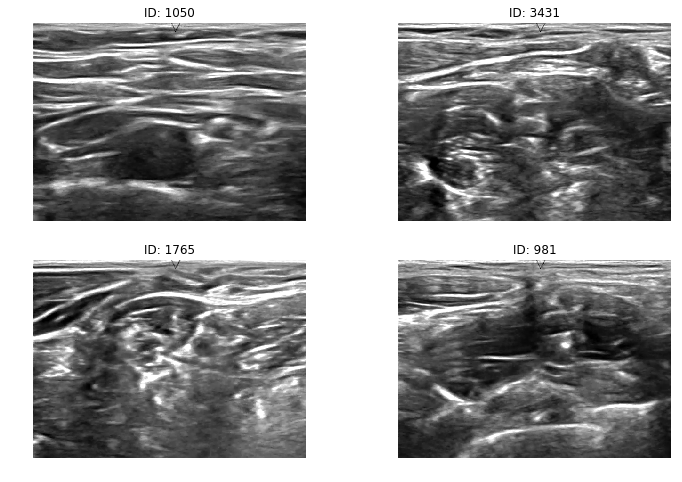

In [7]:
f = plt.figure(figsize=(12, 8))
for i in range(4):
    sp = f.add_subplot(2, 2, i+1)
    sp.axis('Off')
    sp.set_title('ID: {}'.format(test_imgs_id[i]))
    plt.imshow(test_imgs[i, :, :], cmap="gray")

## Training a deep neural network

In [8]:
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

/home/alexej/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 96
img_cols = 96
smooth = 1.

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [11]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_rows, img_cols), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [12]:
imgs_train = preprocess(train_imgs)
imgs_mask_train = preprocess(train_imgs_mask)

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255.  # scale masks to [0, 1]

/home/alexej/tensorflow/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### U-Net

![U-net diagram](../img/u-net-architecture.png)

In [13]:
inputs = Input((img_rows, img_cols, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 48, 48, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [16]:
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss)

model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=20, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint])

Train on 4508 samples, validate on 1127 samples
Epoch 1/20
4508/4508 [==============================] - 11s 2ms/step - loss: -0.6457 - val_loss: -0.5922
Epoch 2/20
4508/4508 [==============================] - 9s 2ms/step - loss: -0.6536 - val_loss: -0.5942
Epoch 3/20
4508/4508 [==============================] - 9s 2ms/step - loss: -0.6576 - val_loss: -0.5948
Epoch 4/20
4508/4508 [==============================] - 9s 2ms/step - loss: -0.6629 - val_loss: -0.5933
Epoch 5/20
4508/4508 [==============================] - 9s 2ms/step - loss: -0.6636 - val_loss: -0.5948
Epoch 6/20
4508/4508 [==============================] - 9s 2ms/step - loss: -0.6689 - val_loss: -0.5930
Epoch 7/20
4508/4508 [==============================] - 9s 2ms/step - loss: -0.6635 - val_loss: -0.5855
Epoch 8/20
4508/4508 [==============================] - 9s 2ms/step - loss: -0.6751 - val_loss: -0.5870
Epoch 9/20
4508/4508 [==============================] - 9s 2ms/step - loss: -0.6822 - val_loss: -0.5808
Epoch 10/20
450

### Some visual inspection of the results

In [15]:
imgs_mask_pred_train = model.predict(imgs_train, verbose=1)

5635/5635 [==============================] - 4s 662us/step


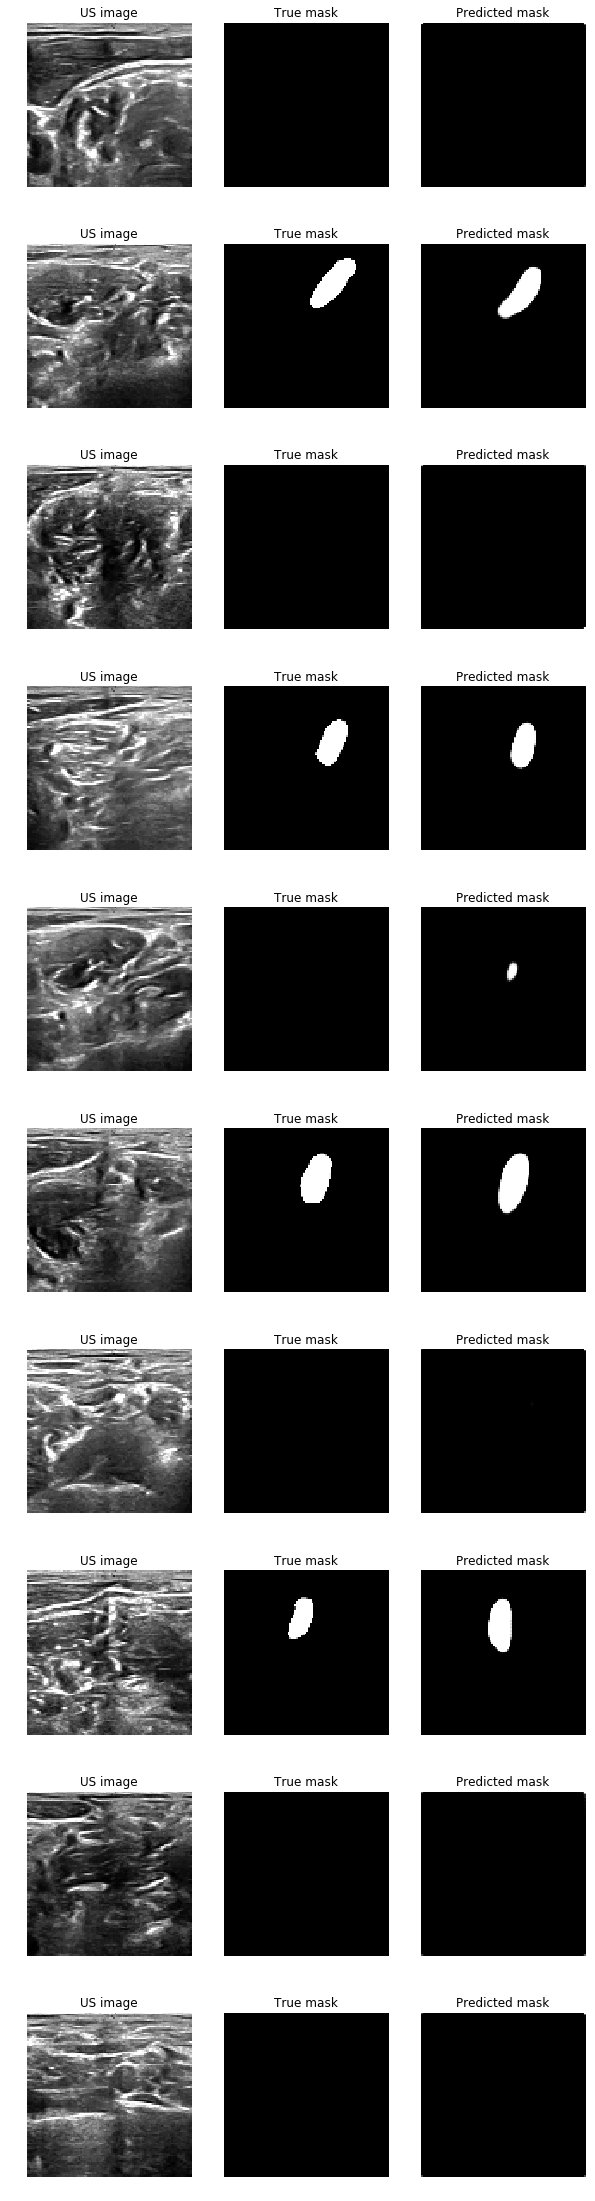

In [16]:
f = plt.figure(figsize=(10, 40))
for i in range(10):
    sp = f.add_subplot(10, 3, 3*i+1)
    sp.axis('Off')
    sp.set_title('US image')
    plt.imshow(imgs_train[i, :, :, 0], cmap="gray")
    
    sp = f.add_subplot(10, 3, 3*i+2)
    sp.axis('Off')
    sp.set_title('True mask')
    plt.imshow(imgs_mask_train[i, :, :, 0], cmap="gray")
    
    sp = f.add_subplot(10, 3, 3*i+3)
    sp.axis('Off')
    sp.set_title('Predicted mask')
    plt.imshow(imgs_mask_pred_train[i, :, :, 0], cmap="gray")

## Test data

In [17]:
imgs_test = preprocess(test_imgs)
imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std

/home/alexej/tensorflow/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [18]:
model.load_weights('weights.h5')

imgs_mask_test = model.predict(imgs_test, verbose=1)
#np.save('imgs_mask_test.npy', imgs_mask_test)

5508/5508 [==============================] - 4s 677us/step


Let's look at some of the predicted masks.

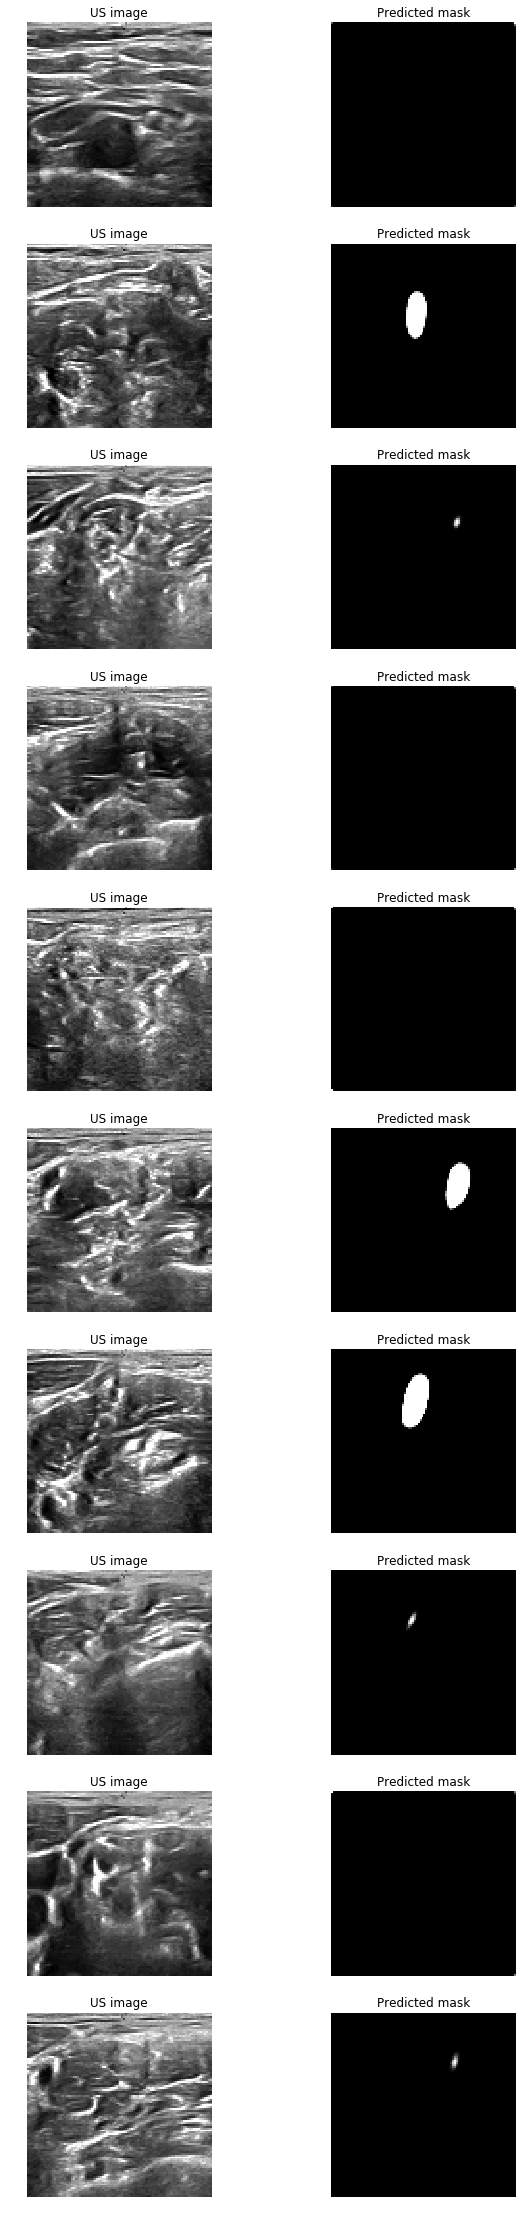

In [19]:
f = plt.figure(figsize=(10, 40))
for i in range(10):
    sp = f.add_subplot(10, 2, 2*i+1)
    sp.axis('Off')
    sp.set_title('US image')
    plt.imshow(imgs_test[i, :, :, 0], cmap="gray")
    
    sp = f.add_subplot(10, 2, 2*i+2)
    sp.axis('Off')
    sp.set_title('Predicted mask')
    plt.imshow(imgs_mask_test[i, :, :, 0], cmap="gray")

Since the input to the U-net was set to 96x96, and all images were rescaled, we need to scale the predicted masks back to the original size for the submission to kaggle leaderboard.

In [20]:
image_rows = 420
image_cols = 580

In [21]:
from itertools import chain
    
def prep(img):
    img = img.astype('float32')
    img = (img > 0.5).astype(np.uint8)  # threshold
    img = resize(img, (image_rows, image_cols), preserve_range=True)
    return img


def run_length_enc(label):
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])

In [22]:
#imgs_mask_test = np.load('imgs_mask_test.npy')
argsort = np.argsort(test_imgs_id)
test_imgs_id = test_imgs_id[argsort]
imgs_mask_test = imgs_mask_test[argsort]

total = imgs_mask_test.shape[0]
ids = []
rles = []
for i in tqdm_notebook(range(total)):
    img = imgs_mask_test[i, :, :, 0]
    img = prep(img)
    rle = run_length_enc(img)

    rles.append(rle)
    ids.append(test_imgs_id[i])

first_row = 'img,pixels'
file_name = 'submission.csv'

with open(file_name, 'w+') as f:
    f.write(first_row + '\n')
    for i in tqdm_notebook(range(total)):
        s = str(ids[i]) + ',' + rles[i]
        f.write(s + '\n')

/home/alexej/tensorflow/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
